## Library

In [ ]:
import os

import pandas as pd
import numpy as np
from datetime import date, datetime
from geopy import distance

from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data

In [ ]:
df_assess = pd.read_excel("/content/drive/MyDrive/PennAthletics/data/Coach_assessment/FH_Colleen_assessment_season_overall.xlsx")
df_assess = df_assess.rename(columns={'User_ID_TBldr': 'User ID'})
df_assess.head()

,name,position,position_1o,player_code_GPS,class year (start),User ID,Player,Ovearall_player_quality,Speed,Endurance,Strength,Skill,prepared_each_day,Grit_perseverance,Grit_passion,Teamwork,Coachability
0,Ainbinder,mid,NaN,A15,2021.0,836288,ainbinder_kate,4,3,5.0,5,5,6,8,4,5,7
1,Banks,def,def_1o,B5,2019.0,585942,banks_gracyn,10,9,8.0,10,9,8,10,8,9,9
2,Bartosz,attack,NaN,B30,2020.0,836290,bartosz_anne,5,1,4.0,5,4,5,8,6,7,7
3,Clarkson,NaN,NaN,NaN,NaN,591602,clarkson_lily,6,1,6.0,2,6,4,2,2,4,3
4,Fagan,NaN,NaN,NaN,NaN,591637,fagan_madison,6,10,3.0,4,4,4,8,9,3,2


In [ ]:
df_ex = pd.read_csv('/content/drive/MyDrive/PennAthletics/Team_Internal/Data/Processed Data/training_data_result.csv')

### Preprocess

In [ ]:
df_ex['Exercise Name'] = df_ex['Exercise Name'].apply(lambda x: x.replace('yd', 'yard'))

In [ ]:
df_ex['Completed Date'] = pd.to_datetime(df_ex['Completed Date'])

df_ex = pd.merge(
    df_ex,
    df_assess[['User ID', 'player_code_GPS']],
    on='User ID'
)

In [ ]:
df_ex_pivot = pd.pivot_table(
    data=df_ex,
    index='User ID',
    columns='Exercise Name',
    values='Result',
    aggfunc='mean'
)

In [ ]:
df_ex_date_pivot = pd.pivot_table(
    df_ex,
    index=['player_code_GPS', 'Completed Date'],
    values='Result',
    columns='Exercise Name'
).reset_index()

In [ ]:
exercise_cols = []
for col in df_ex['Exercise Name'].unique():
  if df_ex_pivot[col].isnull().mean() < 0.3:
    exercise_cols.append(col)

In [ ]:
df_assess = df_assess[['User ID', 'player_code_GPS', 'Ovearall_player_quality', 'Speed', 'Endurance',
                       'Strength', 'Skill', 'prepared_each_day', 'Grit_perseverance', 'Grit_passion',
                       'Teamwork', 'Coachability']]

In [ ]:
df_ex_merge = pd.merge(
    df_ex_pivot,
    df_assess.drop('player_code_GPS', axis=1),
    left_index=True,
    right_on='User ID'
).sort_index()

In [ ]:
df_ex_merge.columns

Index(['1 minute run distance - first rep', '1 minute run distance - last rep',
       '10 yard Sprint', '100 yard Shuttle @ 25 yard intervals',
       '100 yard Shuttle @ 50 yard intervals', '100 yard Sprint',
       '150 yard Shuttle @ 50 yard interval',
       '150 yard Shuttle @ 50 yard intervals', '20 Minute Tempo Run',
       '200 yard Shuttle @ 25 yard intervals',
       ...
       'Ovearall_player_quality', 'Speed', 'Endurance', 'Strength', 'Skill',
       'prepared_each_day', 'Grit_perseverance', 'Grit_passion', 'Teamwork',
       'Coachability'],
      dtype='object', length=112)

In [ ]:
df_ex_merge.isnull().sum().sort_values().head(20)

Coachability                              0
BB Hang Power Clean                       0
User ID                                   0
Ovearall_player_quality                   0
Speed                                     0
HB Jump                                   0
HB Deadlift                               0
Strength                                  0
prepared_each_day                         0
BB Partial Back Squat                     0
Teamwork                                  0
Grit_perseverance                         0
Grit_passion                              0
Skill                                     0
5-0-5 Right                               1
Flying 10                                 1
BB Hang Power Clean w/ Countermovement    1
5-0-5 Left                                1
Broad Jump                                1
30 yard Sprint                            1
dtype: int64

## Exercise Correlation

### Assessment

In [ ]:
df_assess.corr()

<ipython-input-15-e253dcf7c5e4>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_assess.corr()


,User ID,Ovearall_player_quality,Speed,Endurance,Strength,Skill,prepared_each_day,Grit_perseverance,Grit_passion,Teamwork,Coachability
User ID,1.000000,-0.011587,-0.122599,-0.393884,-0.267379,0.163347,0.033682,-0.035314,-0.167773,-0.269227,0.096680
Ovearall_player_quality,-0.011587,1.000000,0.622306,0.425274,0.245232,0.799530,0.527346,0.058090,0.485902,0.264870,0.207149
Speed,-0.122599,0.622306,1.000000,0.452197,0.225765,0.392147,0.516056,0.462317,0.699250,0.232766,0.130842
Endurance,-0.393884,0.425274,0.452197,1.000000,0.397036,0.302145,0.495690,0.108655,0.174083,0.507079,0.466362
Strength,-0.267379,0.245232,0.225765,0.397036,1.000000,0.040257,0.547482,0.363826,0.211018,0.203859,0.447301
Skill,0.163347,0.799530,0.392147,0.302145,0.040257,1.000000,0.355924,-0.064965,0.167593,0.220986,0.329111
prepared_each_day,0.033682,0.527346,0.516056,0.495690,0.547482,0.355924,1.000000,0.368653,0.463090,0.371695,0.372244
Grit_perseverance,-0.035314,0.058090,0.462317,0.108655,0.363826,-0.064965,0.368653,1.000000,0.414557,0.296078,0.400222
Grit_passion,-0.167773,0.485902,0.699250,0.174083,0.211018,0.167593,0.463090,0.414557,1.000000,0.488627,0.026817
Teamwork,-0.269227,0.264870,0.232766,0.507079,0.203859,0.220986,0.371695,0.296078,0.488627,1.000000,0.326902


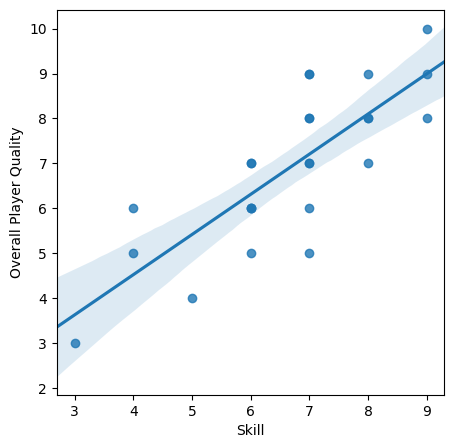

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

sns.regplot(
    data=df_assess,
    x='Skill',
    y='Ovearall_player_quality',
    color='tab:blue',
    truncate=False
)

ax.set(
    ylabel='Overall Player Quality'
)

plt.show()

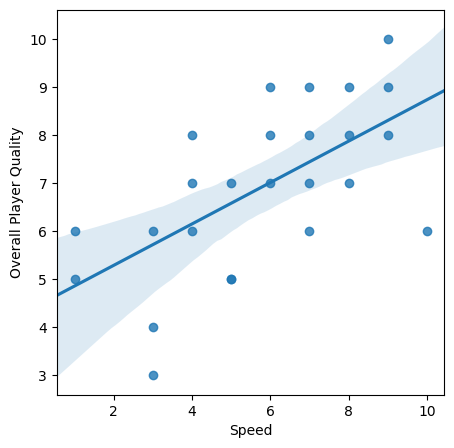

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

sns.regplot(
    data=df_assess,
    x='Speed',
    y='Ovearall_player_quality',
    color='tab:blue',
    truncate=False
)

ax.set(
    ylabel='Overall Player Quality'
)

plt.show()

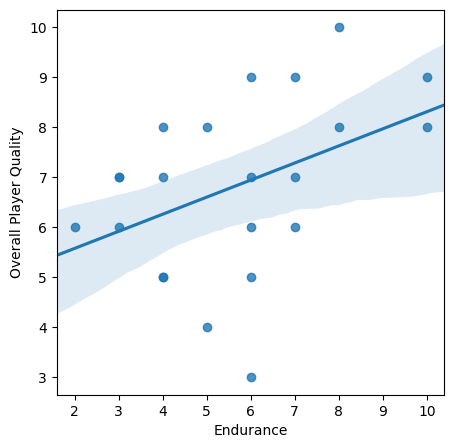

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

sns.regplot(
    data=df_assess,
    x='Endurance',
    y='Ovearall_player_quality',
    color='tab:blue',
    truncate=False
)

ax.set(
    ylabel='Overall Player Quality'
)

plt.show()

### Speed

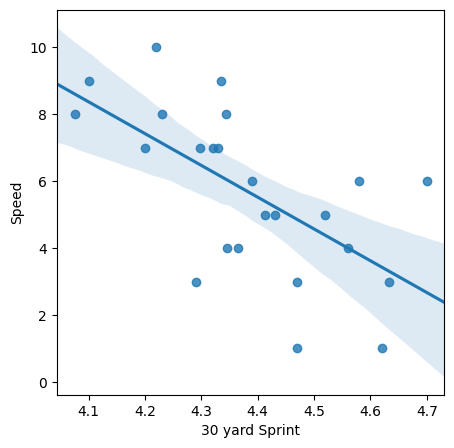

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

sns.regplot(
    data=df_ex_merge,
    x='30 yard Sprint',
    y='Speed',
    color='tab:blue',
    truncate=False
)

plt.show()

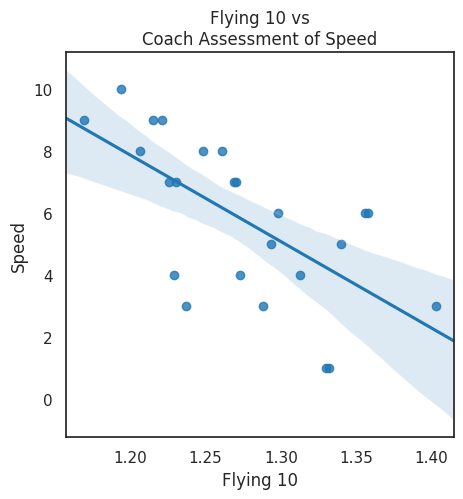

In [ ]:
col = 'Flying 10'
assess = 'Speed'

fig, ax = plt.subplots(figsize=(5, 5))

sns.regplot(
    data=df_ex_merge,
    x=col,
    y=assess,
    color='tab:blue',
    truncate=False
)

ax.set(title='{} vs\nCoach Assessment of {}'.format(col, assess))

plt.show()

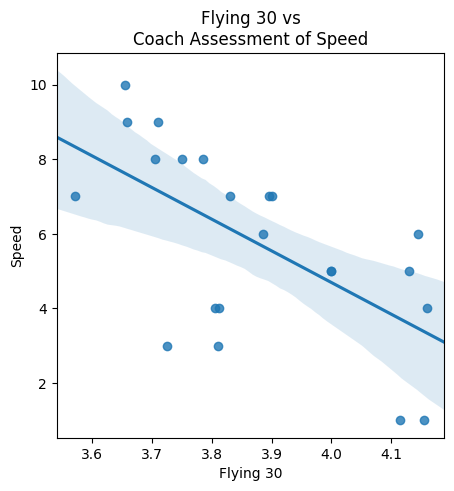

In [ ]:
col = 'Flying 30'
assess = 'Speed'

fig, ax = plt.subplots(figsize=(5, 5))

sns.regplot(
    data=df_ex_merge,
    x=col,
    y=assess,
    color='tab:blue',
    truncate=False
)

ax.set(title='{} vs\nCoach Assessment of {}'.format(col, assess))

plt.show()

In [ ]:
df_ex_merge[['Flying 10', '30 yard Sprint', 'Flying 30', 'Broad Jump', 'Speed']].corr()['Speed']

Flying 10        -0.647320
30 yard Sprint   -0.629992
Flying 30        -0.614411
Broad Jump        0.244631
Speed             1.000000
Name: Speed, dtype: float64

### Endurance

In [ ]:
df_ex_merge[['DB Carry', 'Flying 10', 'Broad Jump', 'Endurance']].corr()['Endurance']

DB Carry     -0.561841
Flying 10    -0.474982
Broad Jump    0.376530
Endurance     1.000000
Name: Endurance, dtype: float64

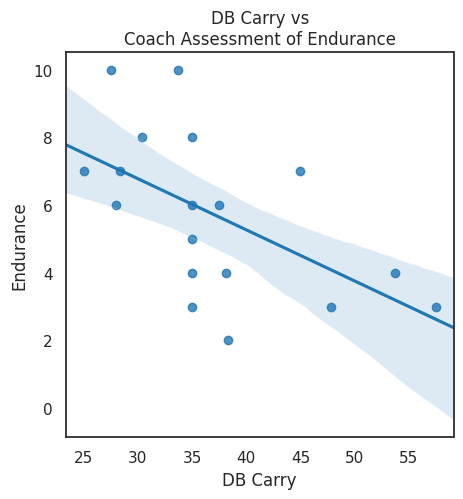

In [ ]:
col = 'DB Carry'
assess = 'Endurance'

fig, ax = plt.subplots(figsize=(5, 5))

sns.regplot(
    data=df_ex_merge,
    x=col,
    y=assess,
    color='tab:blue',
    truncate=False
)

ax.set(title='{} vs\nCoach Assessment of {}'.format(col, assess))

plt.show()

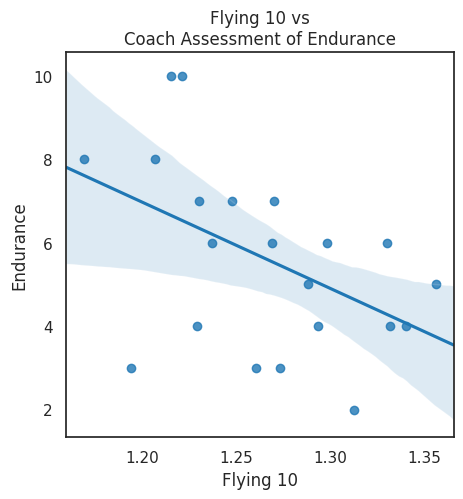

In [ ]:
col = 'Flying 10'
assess = 'Endurance'

fig, ax = plt.subplots(figsize=(5, 5))

sns.regplot(
    data=df_ex_merge,
    x=col,
    y=assess,
    color='tab:blue',
    truncate=False
)

ax.set(title='{} vs\nCoach Assessment of {}'.format(col, assess))

plt.show()

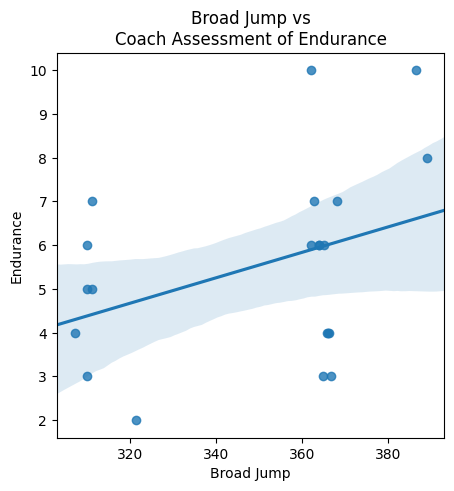

In [ ]:
col = 'Broad Jump'
assess = 'Endurance'

fig, ax = plt.subplots(figsize=(5, 5))

sns.regplot(
    data=df_ex_merge,
    x=col,
    y=assess,
    color='tab:blue',
    truncate=False
)

ax.set(title='{} vs\nCoach Assessment of {}'.format(col, assess))

plt.show()

### Strength

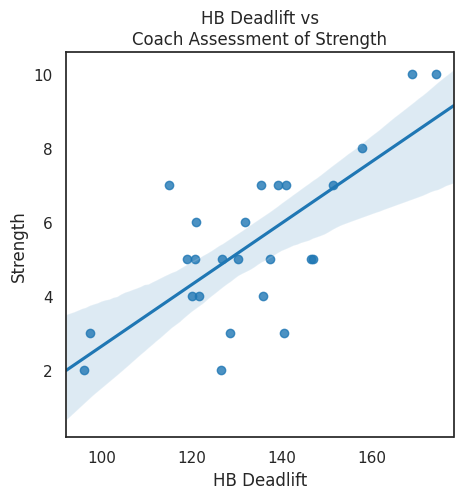

In [ ]:
col = 'HB Deadlift'
assess = 'Strength'

fig, ax = plt.subplots(figsize=(5, 5))

sns.regplot(
    data=df_ex_merge,
    x=col,
    y=assess,
    color='tab:blue',
    truncate=False
)

ax.set(title='{} vs\nCoach Assessment of {}'.format(col, assess))

plt.show()

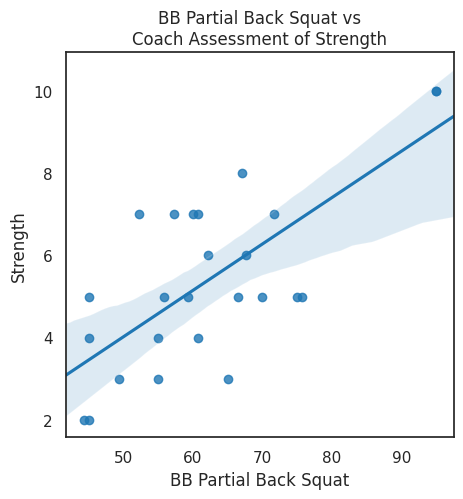

In [ ]:
col = 'BB Partial Back Squat'
assess = 'Strength'

fig, ax = plt.subplots(figsize=(5, 5))

sns.regplot(
    data=df_ex_merge,
    x=col,
    y=assess,
    color='tab:blue',
    truncate=False
)

ax.set(title='{} vs\nCoach Assessment of {}'.format(col, assess))

plt.show()

In [ ]:
df_ex_merge[['BB Partial Back Squat', 'BB Hang Power Clean', 'Flying 10', 'HB Deadlift', 'Strength']].corr()['Strength']

BB Partial Back Squat    0.712688
BB Hang Power Clean      0.682887
Flying 10               -0.466514
HB Deadlift              0.725287
Strength                 1.000000
Name: Strength, dtype: float64

## Linear Regression (LASSO)

In [ ]:
X = df_ex_merge[exercise_cols]
for col in X.columns:
  X[col] = X[col].fillna(X[col].mean())

<ipython-input-14-c8ec4c3da013>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].fillna(X[col].mean())


<Axes: >

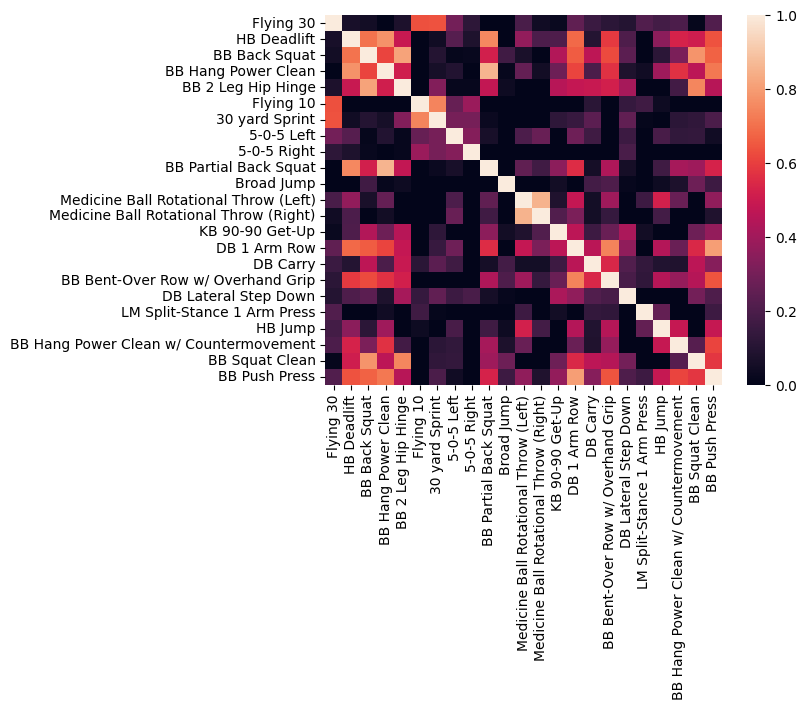

In [ ]:
sns.heatmap(X.corr(), vmin=0, vmax=1)

In [ ]:
scaler = StandardScaler()

y = df_ex_merge['Speed']

X_scaled = scaler.fit_transform(X.loc[y.notnull()])

y = y[y.notnull()]
lr = Lasso(alpha=0.5)
lr.fit(X_scaled, y)
y_pred = lr.predict(X_scaled)
r2_score(y, y_pred)

0.6037688547414899

In [ ]:
coef = pd.DataFrame({
    'feature': X.columns,
    'coefficient': lr.coef_
    }).sort_values(by='coefficient', key=lambda x: abs(x), ascending=False)
coef

,feature,coefficient
5,Flying 10,-0.950240
4,BB 2 Leg Hip Hinge,-0.593884
0,Flying 30,-0.242018
8,5-0-5 Right,-0.128341
17,DB Lateral Step Down,-0.057910
13,KB 90-90 Get-Up,0.000000
21,BB Squat Clean,-0.000000
20,BB Hang Power Clean w/ Countermovement,-0.000000
19,HB Jump,0.000000
18,LM Split-Stance 1 Arm Press,0.000000


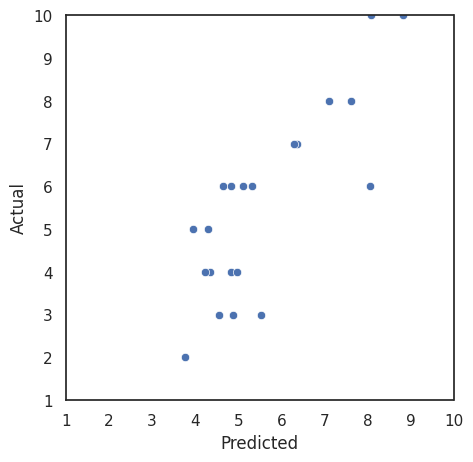

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

sns.scatterplot(x=y_pred, y=y)

ax.set(
    xlabel='Predicted',
    ylabel='Actual',
    xlim=(1, 10),
    ylim=(1, 10),
    xticks=range(1, 11),
    yticks=range(1, 11)
)

plt.show()

## GPS

In [ ]:
df_gps = pd.read_csv('/content/drive/MyDrive/PennAthletics/Team_Internal/Data/Processed Data/gps_data.csv')

### Preprocess

In [ ]:
df_gps['Timestamp'] = pd.to_datetime(df_gps['Timestamp'])

In [ ]:
df_gps['Timestamp'] = df_gps['Timestamp'].round('S')

In [ ]:
df_gps = df_gps.drop_duplicates(subset=['Athlete', 'Timestamp'], keep='first')

In [ ]:
df_gps['Date'] = df_gps['Timestamp'].dt.date

In [ ]:
df_gps['Athlete'].unique()

array(['A15', 'B5', 'F16', 'R9', 'K11', 'K10', 'L8', 'M6', 'S7', 'V1',
       'W2', 'Z4', 'H13', 'W3', 'F14', 'Z1', 'Farrell', 'F12'],
      dtype=object)

In [ ]:
df_assess_gps = df_assess.loc[df_assess['player_code_GPS'].notnull()].set_index('player_code_GPS')

### Speed

In [ ]:
df_gps_speed = df_gps.loc[df_gps['Speed']>0]

In [ ]:
df_gps_speed['Accel'] = np.sqrt(df_gps_speed['Accel X']**2 + df_gps_speed['Accel Y']**2)

<ipython-input-161-6f929ecc7c10>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gps_speed['Accel'] = np.sqrt(df_gps_speed['Accel X']**2 + df_gps_speed['Accel Y']**2)


In [ ]:
df_gps_speed_game = pd.pivot_table(
    df_gps_speed,
    index=['Athlete', 'Date'],
    values=['Speed', 'Accel'],
    aggfunc='median'
).reset_index()

In [ ]:
df_gps_speed_pivot = pd.pivot_table(
    df_gps_speed,
    index='Athlete',
    values=['Speed', 'Accel'],
    aggfunc=['mean', 'max', 'median']
)

In [ ]:
df_gps_speed_pivot.columns = [col[1] + '_' + col[0] for col in df_gps_speed_pivot.columns]

In [ ]:
for athlete in df_gps_speed['Athlete'].unique():
  df_gps_speed.loc[df_gps_speed['Athlete']==athlete, 'Speed_geq_mean'] = df_gps_speed.loc[df_gps_speed['Athlete']==athlete, 'Speed'] >= df_gps_speed_pivot.loc[athlete, 'Speed_mean']

In [ ]:
df_gps_speed_pivot['Speed_geq_mean'] = pd.pivot_table(
    df_gps_speed,
    index='Athlete',
    values='Speed_geq_mean',
    aggfunc='mean'
)['Speed_geq_mean']

### Distance

In [ ]:
df_gps_dist = df_gps[['Athlete', 'Game', 'Latitude', 'Longitude']]

In [ ]:
df_gps_dist['Latitude_prev'] = df_gps_dist.groupby(['Athlete', 'Game'])['Latitude'].shift()
df_gps_dist['Longitude_prev'] = df_gps_dist.groupby(['Athlete', 'Game'])['Longitude'].shift()

<ipython-input-30-e4ab1c0e1ce8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gps_dist['Latitude_prev'] = df_gps_dist.groupby(['Athlete', 'Game'])['Latitude'].shift()
<ipython-input-30-e4ab1c0e1ce8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gps_dist['Longitude_prev'] = df_gps_dist.groupby(['Athlete', 'Game'])['Longitude'].shift()


In [ ]:
df_gps_dist = df_gps_dist.loc[df_gps_dist['Latitude_prev'].notnull()]

In [ ]:
df_gps_dist['distance'] = df_gps_dist.apply(
    lambda x: distance.distance(
        (x['Latitude_prev'], x['Longitude_prev']),
        (x['Latitude'], x['Longitude'])
    ), axis=1
)

In [ ]:
df_gps_dist['distance_km'] = df_gps_dist['distance'].apply(lambda x: x.km)
df_gps_dist['distance_miles'] = df_gps_dist['distance'].apply(lambda x: x.miles)

In [ ]:
df_gps_dist_game = pd.pivot_table(
    df_gps_dist,
    index=['Athlete', 'Game'],
    values='distance_miles',
    aggfunc='sum'
).reset_index()

In [ ]:
df_gps_dist_pivot = pd.pivot_table(
    df_gps_dist_game,
    index='Athlete',
    values='distance_miles',
    aggfunc=['mean', 'max', 'median', 'sum']
)

In [ ]:
df_gps_dist_pivot.columns = [col[1] + '_' + col[0] for col in df_gps_dist_pivot.columns]

### Merge

In [ ]:
df_gps_merge = pd.merge(
    df_assess_gps,
    df_gps_speed_pivot,
    left_index=True,
    right_index=True
)

df_gps_merge = pd.merge(
    df_gps_merge,
    df_gps_dist_pivot,
    left_index=True,
    right_index=True
)

df_gps_merge = pd.merge(
    df_gps_merge,
    df_ex_pivot[exercise_cols],
    left_on='User ID',
    right_on='User ID'
)

## GPS Correlation

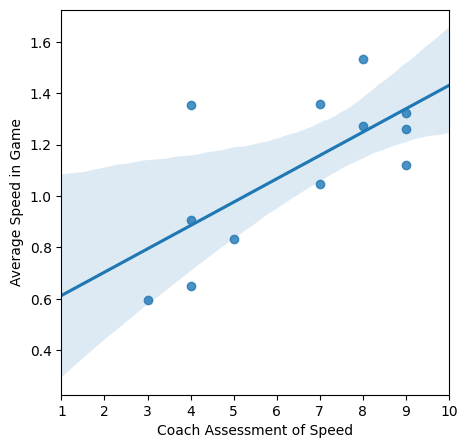

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

plt.xlim((1, 10))

sns.regplot(
    df_gps_merge,
    x='Speed',
    y='Speed_mean',
    color='tab:blue',
    truncate=False
)

ax.set(
    xlabel='Coach Assessment of Speed',
    ylabel='Average Speed in Game',
    xlim=(1, 10),
    xticks=range(1, 11)
)

plt.show()

In [ ]:
df_gps_merge.corr()['Speed_median'].sort_values(key=lambda x: abs(x), ascending=False)

Speed_median                              1.000000
Speed_mean                                0.972426
distance_miles_median                     0.845684
distance_miles_mean                       0.836559
Ovearall_player_quality                   0.829413
Speed_geq_mean                            0.817118
Broad Jump                                0.734033
distance_miles_max                        0.722609
Speed                                     0.696167
30 yard Sprint                           -0.694070
Flying 10                                -0.667475
Speed_max                                 0.655921
distance_miles_sum                        0.628941
prepared_each_day                         0.577559
Skill                                     0.552839
Grit_passion                              0.552808
Endurance                                 0.468789
Strength                                  0.407734
5-0-5 Left                               -0.373495
BB 2 Leg Hip Hinge             

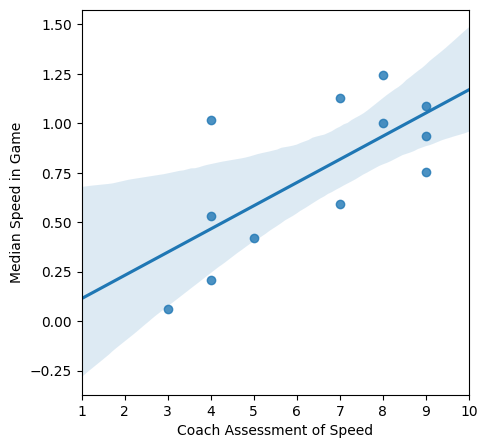

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

plt.xlim((1, 10))

sns.regplot(
    df_gps_merge,
    x='Speed',
    y='Speed_median',
    color='tab:blue',
    truncate=False
)

ax.set(
    xlabel='Coach Assessment of Speed',
    ylabel='Median Speed in Game',
    xlim=(1, 10),
    xticks=range(1, 11)
)

plt.show()

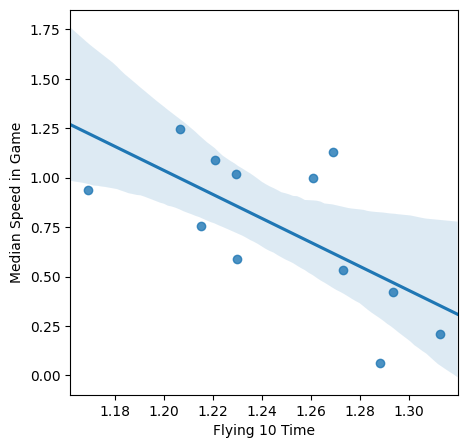

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

sns.regplot(
    df_gps_merge,
    x='Flying 10',
    y='Speed_median',
    color='tab:blue',
    truncate=False
)

ax.set(
    xlabel='Flying 10 Time',
    ylabel='Median Speed in Game',
)

plt.show()

In [ ]:
df_gps_merge.corr()['Accel_median'].sort_values(key=lambda x: abs(x), ascending=False)

Accel_median                              1.000000
Accel_mean                                0.893360
Grit_perseverance                        -0.717830
Accel_max                                 0.598069
distance_miles_sum                       -0.536471
30 yard Sprint                            0.535920
Endurance                                -0.496520
Speed                                    -0.462260
Flying 10                                 0.454651
distance_miles_median                    -0.436113
BB Hang Power Clean w/ Countermovement   -0.401853
distance_miles_mean                      -0.401593
distance_miles_max                       -0.397787
Coachability                             -0.390721
HB Deadlift                              -0.359093
5-0-5 Right                               0.351549
Speed_max                                -0.345210
HB Jump                                   0.344118
Teamwork                                 -0.322447
Speed_geq_mean                 

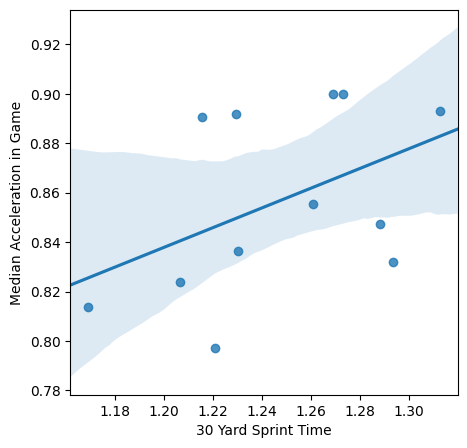

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.regplot(
    df_gps_merge,
    x='30 yard Sprint',
    y='Accel_median',
    color='tab:blue',
    truncate=False
)

ax.set(
    xlabel='30 Yard Sprint Time',
    ylabel='Median Acceleration in Game',
)

plt.show()

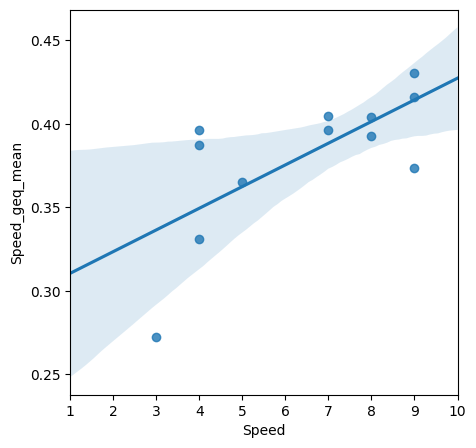

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

plt.xlim((1, 10))

sns.regplot(
    df_gps_merge,
    x='Speed',
    y='Speed_geq_mean',
    color='tab:blue',
    truncate=False
)

ax.set(
    xlim=(1, 10),
    xticks=range(1, 11)
)

plt.show()

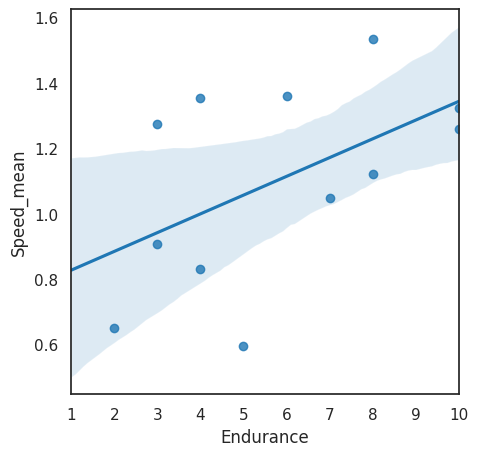

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

plt.xlim((1, 10))

sns.regplot(
    df_gps_merge,
    x='Endurance',
    y='Speed_mean',
    color='tab:blue',
    truncate=False
)

ax.set(
    xlim=(1, 10),
    xticks=range(1, 11)
)

plt.show()

In [ ]:
df_gps_merge.corr()['distance_miles_mean'].sort_values(key=lambda x: abs(x), ascending=False)

distance_miles_mean                       1.000000
distance_miles_median                     0.989735
distance_miles_max                        0.935327
Speed_mean                                0.846213
Speed_median                              0.836559
distance_miles_sum                        0.826108
30 yard Sprint                           -0.803594
Flying 10                                -0.776465
Speed_max                                 0.768402
Ovearall_player_quality                   0.705096
Speed                                     0.680212
Endurance                                 0.645064
Speed_geq_mean                            0.641953
prepared_each_day                         0.616199
Grit_passion                              0.584508
Broad Jump                                0.553637
Strength                                  0.549319
User ID                                  -0.504975
Teamwork                                  0.452203
Skill                          

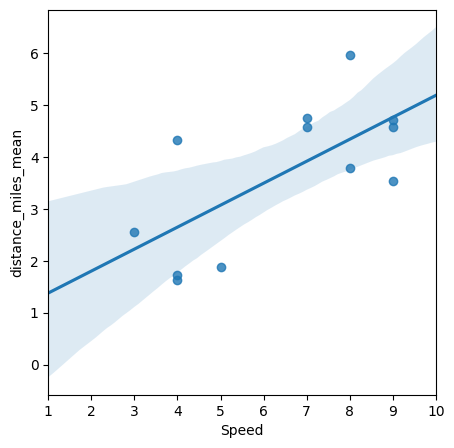

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

plt.xlim((1, 10))

sns.regplot(
    df_gps_merge,
    x='Speed',
    y='distance_miles_mean',
    color='tab:blue',
    truncate=False
)

ax.set(
    xlim=(1, 10),
    xticks=range(1, 11)
)

plt.show()

In [ ]:
df_gps_merge[['Speed', 'Endurance', 'distance_miles_max']].corr()

,Speed,Endurance,distance_miles_max
Speed,1.000000,0.765618,0.686938
Endurance,0.765618,1.000000,0.755919
distance_miles_max,0.686938,0.755919,1.000000


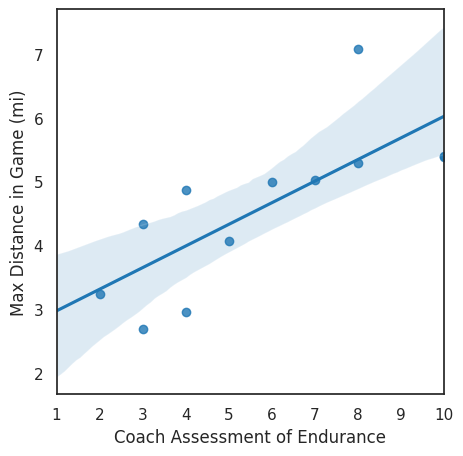

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

plt.xlim((1, 10))

sns.regplot(
    df_gps_merge,
    x='Endurance',
    y='distance_miles_max',
    color='tab:blue',
    truncate=False
)

ax.set(
    xlabel='Coach Assessment of Endurance',
    ylabel='Max Distance in Game (mi)',
    xlim=(1, 10),
    xticks=range(1, 11)
)

plt.show()

### Time Series

In [ ]:
df_ex['Exercise Name'].value_counts().head(10)

HB Deadlift                             697
BB Hang Power Clean                     529
Flying 10                               489
HB Jump                                 435
BB Partial Back Squat                   221
BB 2 Leg Hip Hinge                      174
BB Front Squat                          146
BB Squat Clean                          137
BB Back Squat                           126
100 yard Shuttle @ 25 yard intervals    124
Name: Exercise Name, dtype: int64

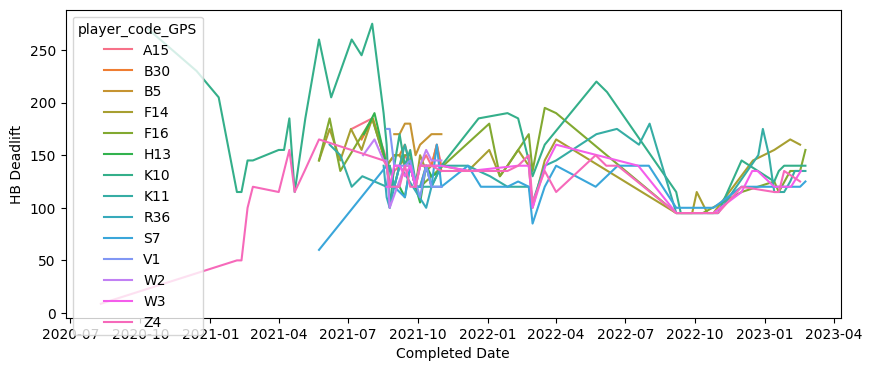

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))

sns.lineplot(
    df_ex_date_pivot,
    x='Completed Date',
    y='HB Deadlift',
    hue='player_code_GPS'
)

plt.show()

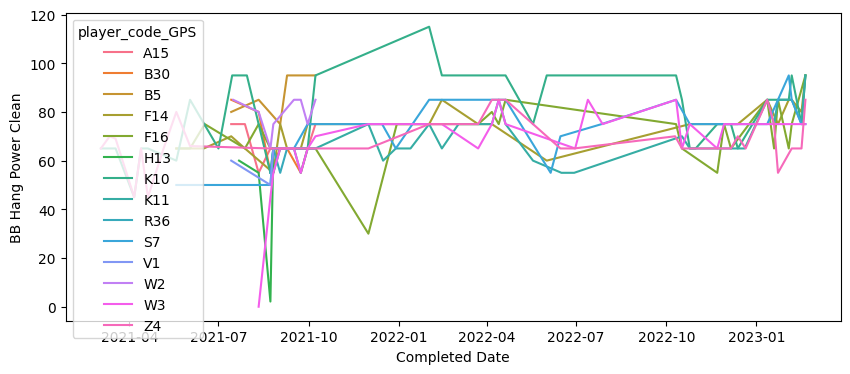

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))

sns.lineplot(
    df_ex_date_pivot,
    x='Completed Date',
    y='BB Hang Power Clean',
    hue='player_code_GPS'
)

plt.show()

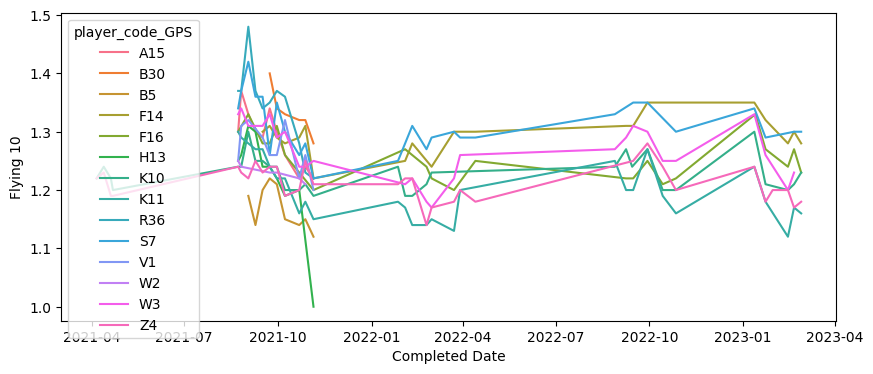

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))

sns.lineplot(
    df_ex_date_pivot,
    x='Completed Date',
    y='Flying 10',
    hue='player_code_GPS'
)

plt.show()

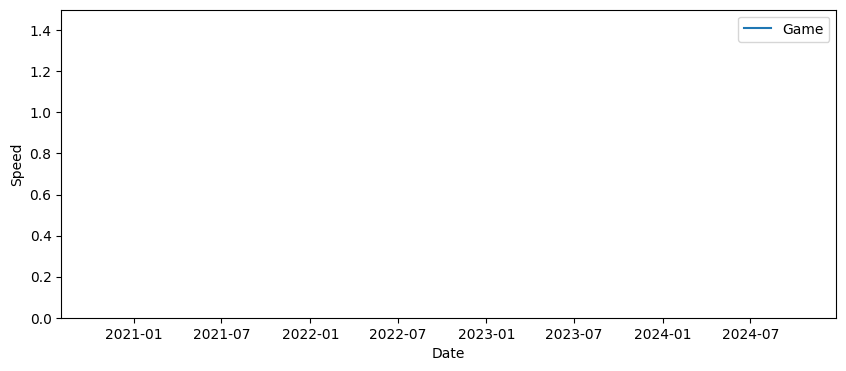

In [ ]:
athlete = df_gps_speed_game['Athlete'].unique()[16]

fig, ax = plt.subplots(figsize=(10, 4))

sns.lineplot(
    df_gps_speed_game.loc[df_gps_speed_game['Athlete']==athlete],
    x='Date',
    y='Speed',
    label='Game'
)

sns.lineplot(
    df_ex_date_pivot.loc[df_ex_date_pivot['player_code_GPS']==athlete],
    x='Completed Date',
    y='Flying 10',
    label='Exercise'
)

ax.set(ylim=(0, 1.5))

plt.legend()

plt.show()